In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_rows',5000)
import os
from glob import iglob

In [21]:
# Load all structural p-values across both analyses
df = pd.read_csv("/Volumes/sivleyrm/pdbmap/results/specialK_analysis_2016-05-27/exac/daf_K_summary.txt",delimiter='\t')
df = df.drop_duplicates(["structid","chain"])

In [22]:
print "Number of structures evaluated:"
print len(df)
print "Number of variants evluated:"
print "%.0f"%np.sum(df["N"])

from qvalue import estimate
THRESH = 0.1

df.ix[~df[ "Kp"].isnull(), "Kq"], K_lam, K_pi = estimate(df.ix[~df[ "Kp"].isnull(), "Kp"].values)
df.ix[~df["wKp"].isnull(),"wKq"],wK_lam,wK_pi = estimate(df.ix[~df["wKp"].isnull(),"wKp"].values)

print "\nProteins passing an FDR of %.0f%% for the unweighted analysis"%(THRESH*100)
print "Significant:   %4d"%( df['Kq']<THRESH).sum()
print "    Clustered: %4d"%((df['Kq']<THRESH) & (df["Kz"]>0)).sum()
print "    Dispersed: %4d"%((df['Kq']<THRESH) & (df["Kz"]<0)).sum()

print "\nProteins passing an FDR of %.0f%% for the weighted analysis"%(THRESH*100)
print "Significant:   %4d"%(df["wKq"]<THRESH).sum()
print "    Clustered: %4d"%((df["wKq"]<THRESH) & (df.ix[~df["wKp"].isnull(),"wKz"]>0)).sum()
print "    Dispersed: %4d"%((df["wKq"]<THRESH) & (df.ix[~df["wKp"].isnull(),"wKz"]<0)).sum()

Number of structures evaluated:
4509
Number of variants evluated:
196176

Proteins passing an FDR of 10% for the unweighted analysis
Significant:     44
    Clustered:   16
    Dispersed:   28

Proteins passing an FDR of 10% for the weighted analysis
Significant:      0
    Clustered:    0
    Dispersed:    0


In [24]:
df.to_csv("/Volumes/sivleyrm/pdbmap/results/ripleysK_results/pdb_exac_missense_univariate.txt",
            header=False,index=False,sep="\t",na_rep="\N")

In [8]:
df.head(1)

,structid,chain,R,N,P,T,K,Kp,Kz,Kzp,wP,wT,wK,wKp,wKz,wKzp,Kq,wKq
0,2EQM,A,81,8,99999,10,1.558506,0.48974,-0.73494,0.462376,NaN,NaN,NaN,NaN,NaN,NaN,0.727644,NaN


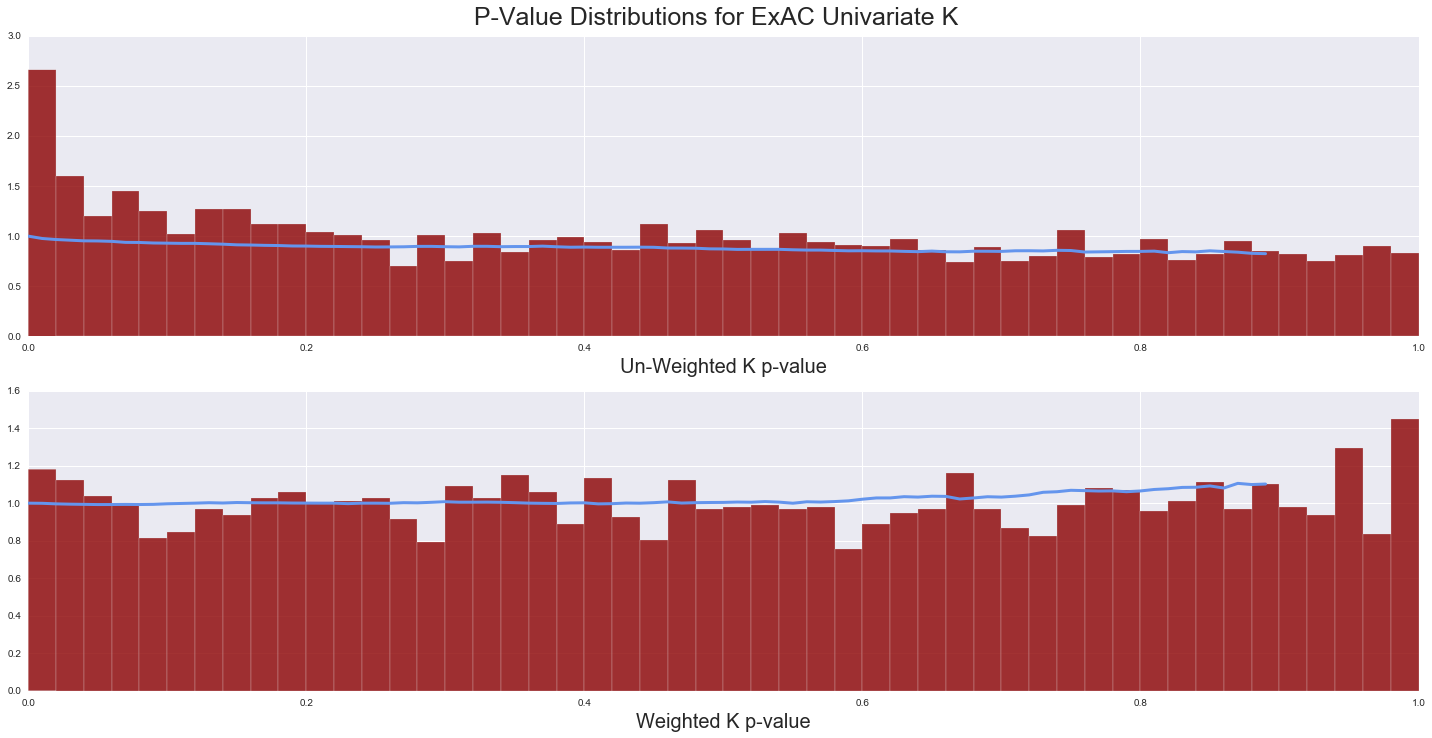

In [5]:
# P-Value Distributions
fig,ax = plt.subplots(2,1,figsize=(20,10))
plt.suptitle("P-Value Distributions for ExAC Univariate K",fontsize=25,y=1.02)
ax[0].set_xlabel("Un-Weighted K p-value",fontsize=20)
# ax[0].hist(df["Kzp"],bins=np.arange(0,1.02,0.02),color="darkblue",normed=True)
ax[0].hist(df["Kp"],bins=np.arange(0,1.02,0.02),color="darkred",alpha=0.8,normed=True)
ax[0].plot(K_lam,K_pi,lw=3,c='cornflowerblue')
ax[1].set_xlabel("Weighted K p-value",fontsize=20)
# ax[1].hist(df["wKzp"],bins=np.arange(0,1.02,0.02),color="darkblue",normed=True)
ax[1].hist(df["wKp"],bins=np.arange(0,1.02,0.02),color="darkred",alpha=0.8,normed=True)
ax[1].plot(wK_lam,wK_pi,lw=3,c='cornflowerblue')
plt.tight_layout()
plt.show()

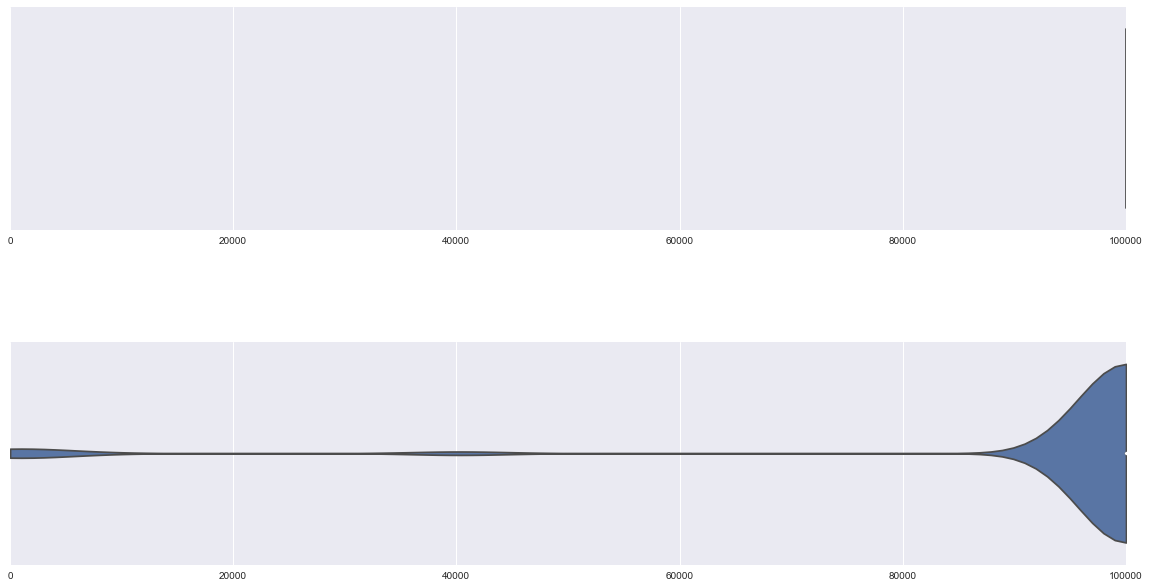

In [6]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
sns.violinplot(df['P'].values, cut=0,ax=ax[0])
sns.violinplot(df['wP'].values,cut=0,ax=ax[1])
ax[0].set_xlim([0,100000])
ax[1].set_xlim([0,100000])
plt.show()

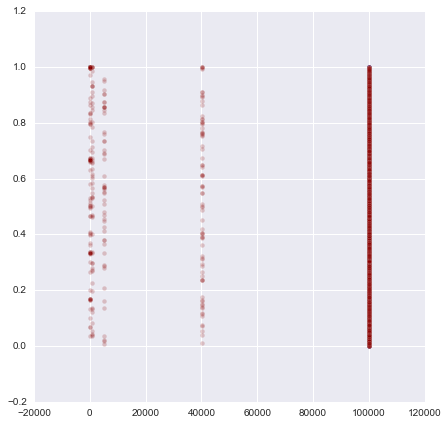

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(df["P"],df["Kp"],c="mediumblue",alpha=0.2)
plt.scatter(df["wP"],df["wKp"],c="darkred",alpha=0.2)

Fully permuted:      4174
Partially permuted:   335
Proportion of p=1.0 w/ <100k permutations: 0.98
Proteins w/ wKp=1.0:   46


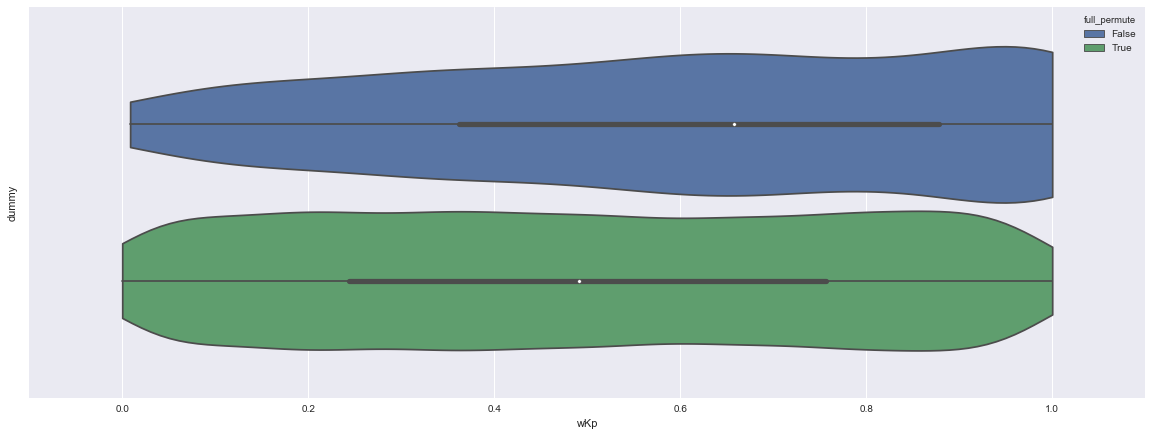

In [8]:
tdf = df.copy()
tdf["full_permute"] = tdf["wP"]==99999
print "Fully permuted:      %4d"%tdf["full_permute"].sum()
print "Partially permuted:  %4d"%(len(tdf)-tdf["full_permute"].sum())
print "Proportion of p=1.0 w/ <100k permutations: %.2f"%(((tdf["wKp"]==1.0) & ~(tdf["full_permute"])).sum() / float((tdf["wKp"]==1.0).sum()))
print "Proteins w/ wKp=1.0: %4d"%(tdf["wKp"]==1.0).sum()
tdf['dummy'] = ''
plt.figure(figsize=(20,7))
sns.violinplot(x='wKp',y='dummy',hue='full_permute',data=tdf,cut=0)
plt.xlim([-0.1,1.1])
plt.show()

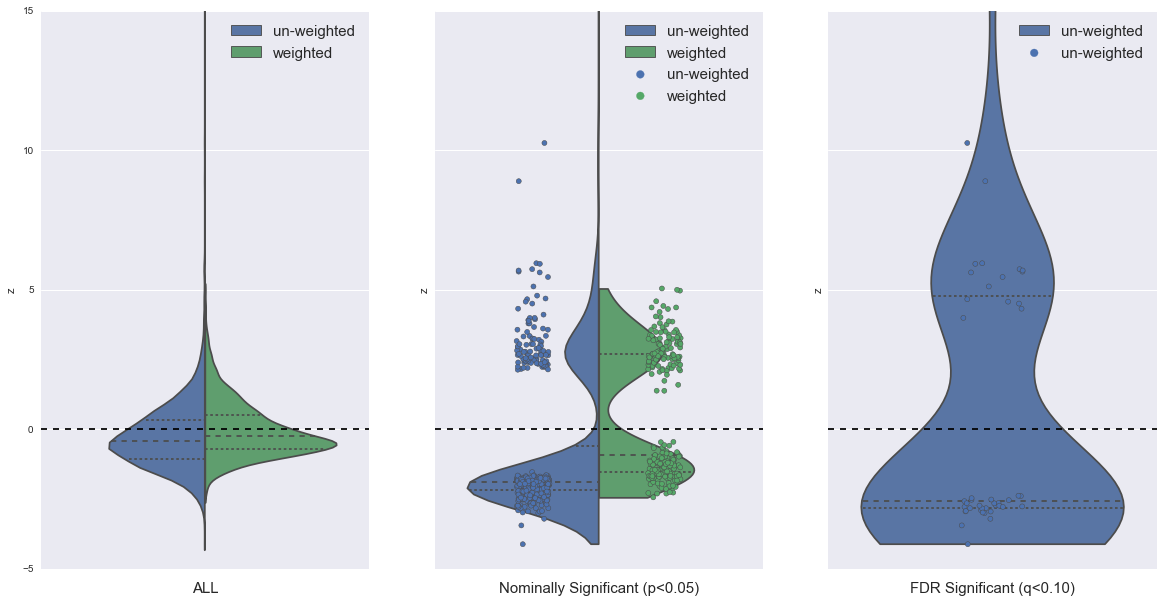

In [9]:
dfu = pd.DataFrame(df[["Kp","Kz"]].values,columns=["p","z"])
dfu.ix[~dfu["p"].isnull(),'q'] = estimate(dfu.ix[~dfu["p"].isnull(),"p"].values)[0]
dfu["w"] = "un-weighted"
dfw = pd.DataFrame(df[["wKp","wKz"]].values,columns=["p","z"])
dfw['w'] = "weighted"
dfw.ix[~dfw['p'].isnull(),'q'] = estimate(dfw.ix[~dfw['p'].isnull(),"p"].values)[0]
dfv = pd.concat((dfu,dfw))
dfv['dummy'] = ""

fig,ax = plt.subplots(1,3,figsize=(20,10),sharey=True)
sns.violinplot(x='dummy',y="z",hue='w',data=dfv,ax=ax[0],cut=1,orient='v',split=True,inner='quart')
dfv1 = dfv[dfv["p"]<0.05]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[1],orient='v',split=True,jitter=True,lw=0.5)
dfv1 = dfv[dfv["q"]<THRESH]
if not dfv1.empty:
    split = (dfv1["w"]=="weighted").sum() > 0
    sns.violinplot(x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=split,cut=0,inner='quart')
    sns.stripplot( x='dummy',y="z",hue='w',data=dfv1,ax=ax[2],orient='v',split=True,jitter=True,lw=0.5)
ax[0].set_xlabel("ALL",fontsize=15)
ax[1].set_xlabel("Nominally Significant (p<0.05)",fontsize=15)
ax[2].set_xlabel("FDR Significant (q<%.2f)"%THRESH,fontsize=15)
ax[0].legend(fontsize=15)
ax[1].legend(fontsize=15)
ax[2].legend(fontsize=15)
plt.ylim([-5,15])
ax[0].axhline(0.,ls='dashed',c='black')
ax[1].axhline(0.,ls='dashed',c='black')
ax[2].axhline(0.,ls='dashed',c='black')
plt.show()

In [10]:
print "Un-Weighted: FDR-Significant Proteins"
print df.ix[df["Kq"]<0.1,["structid","chain","Kz","Kp","Kq"]]

print "\nWeighted: FDR-Significant Proteins"
print df.ix[df["wKq"]<0.1,["structid","chain","wKz","wKp","wKq"]]

Un-Weighted: FDR-Significant Proteins
     structid chain         Kz       Kp        Kq
366      1ZED     A   5.119662  0.00010  0.043942
472      3U9J     A  -2.392783  0.00100  0.092955
496      2OO4     A  -2.538858  0.00114  0.096335
639      2BEC     A  -3.002220  0.00014  0.043942
732      3F0W     A  -2.380665  0.00108  0.095610
759      2C0M     F  -3.444824  0.00004  0.024788
901      1V27     A  -2.726695  0.00046  0.063347
1032     3V2W     A  -2.525869  0.00086  0.086423
1057     3I3T     G  -2.644180  0.00054  0.064768
1268     1T8U     B   4.663044  0.00066  0.074364
1275     1WXT     A  -2.575398  0.00038  0.058871
1521     2LLY     A  -2.468346  0.00090  0.088062
1709     2O36     A  -3.207242  0.00026  0.043942
1851     6PAX     A   5.621773  0.00062  0.072040
1856     2HHL     B  -2.826910  0.00002  0.014873
1944     3MOP     C  -2.653976  0.00080  0.084987
2013     3K0W     A  -2.517595  0.00112  0.096335
2413     3AHR     A  -2.780266  0.00026  0.043942
2537     3IJ

In [15]:
# SigClust
print df.ix[((df["Kq"]<0.1) & (df["Kz"]>0)) | ((df["wKq"]<0.1) & df["wKq"]>0),["structid","chain"]]

     structid chain
366      1ZED     A
1268     1T8U     B
1851     6PAX     A
2537     3IJ9     A
2595     3AQG     B
2599     3FE1     B
3134     1U6G     C
3231     3E9L     A
3841     1J1E     D
3907     3HLK     B
3919     3AV1     E
4282     4F8Q     A
4291     1IHI     B
4302     4F8T     A
4463     3EVI     A
4496     2Q7Z     A


In [16]:
# SigDisp
print df.ix[((df["Kq"]<0.1) & (df["Kz"]<0)) | ((df["wKq"]<0.1) & df["wKq"]<0),["structid","chain"]]

     structid chain
472      3U9J     A
496      2OO4     A
639      2BEC     A
732      3F0W     A
759      2C0M     F
901      1V27     A
1032     3V2W     A
1057     3I3T     G
1275     1WXT     A
1521     2LLY     A
1709     2O36     A
1856     2HHL     B
1944     3MOP     C
2013     3K0W     A
2413     3AHR     A
2548     3HHD     C
2795     3L4G     B
2865     3GT8     C
2894     1OZN     A
3071     3B6V     A
3339     1MSV     A
3476     4DHF     A
3634     3DLX     A
3738     3BE2     A
3960     1P22     A
4240     1R6T     A
4305     1QSC     A
4459     4FBN     A


In [17]:
# NonSig
print df.ix[(df["Kq"]>0.1) & (df["wKq"]>0.1),["structid","chain"]]

        structid chain
1           2EPT     A
2           2EQE     A
3           2EGA     A
4           2EPW     A
5           2EPZ     A
6           2EE1     A
7           2EQ3     A
8           2EZY     A
9           2EW3     A
10          2EKF     A
11          2EMV     A
12          2EM3     A
13          2EDV     A
14          2EV8     A
15          2EQO     A
16          2F5Y     A
17          2EK1     B
18          2EOH     A
19          2EOO     A
20          2EPA     A
21          2EEL     A
22          2ENE     A
23          2EM6     A
24          2EEH     A
25          2EQX     A
26          2EED     A
27          2EP8     A
28          2EQS     A
29          2EMP     A
30          2EMW     A
31          2ENZ     A
32          2EMG     A
33          2F60     K
34          2ERR     A
35          2EKO     A
36          2EDY     A
37          2EQU     A
38          2EJM     A
39          2ERX     A
40          2EGM     A
41          2F0X     A
42          2EW1     A
43         